
# Finite Element Method for Heat Exchangers

Suppose we have a couple of fluid streams exchanging heat (or mass) and want to compute the amount of heat (or mass) exchanged under given conditions of flow configuration and overall heat transfer coefficient U and area through the process. Furthermore, the streams are real -- defined numerically by points (Q,T) or an interpolate, instead of constant stream heat capacity. We want a method that converges with spatial resolution and converges with time for steady-state boundary conditions, and that hopefully gives a reasonable guess for transient conditions. Let's start with some assumptions:

- We want a method that is first order in time, and preferably explicit.
- The method may be spatially implicit.
- The inlets (fluid state and rate of change) are specified as a boundary condition.
- We have all the information we need about U, A, cross-section area, mass flow rate, and density
- It is okay to violate transient conservation of energy insofar as we choose to treat flow as incompressible.
- Assume the fluid state in a given cross-section is uniform, so we are not concerned with spatial resolution of the boundary layer, mixing, etc. 
- Assume that only advection acts to carry information downstream, ie. flow is fast enough to neglect heat transfer between points in the same stream.
- Interacting streams are coupled only through local heat transfer, eg. the forcing term.

As a result of some of the assumptions, it is possible for the method to overshoot, so let's keep the time step smallish.

## Finite difference schemes

### Explicit method

The obvious starting point is to draw a cell with some $U \Delta A$, write out the transient first law, and extract the relevant equations for the rate of change of state. I'm going to define states at the inlet and outlet to the cell. So we have for one cell

$$ \Delta Q = \dot{m} (h_{out} - h_{in}) + \frac{d}{dt} \int_{cell} u dm $$

Now we need to provide an finite element approximation of the mass integral / time rate of change term and estimate $\Delta Q$ resulting from interaction with the other stream. First, let's use a first order central method for the integral term:

\begin{align}
    \int_{cell} u dm &\approx (\rho A_c \Delta x)
    \left(\frac{1}{2}\right)\left(u_{in}+u_{out}\right) \\
    &= \left(\frac{1}{2}\right) (\alpha \dot{m}) \left(u_{in}+u_{out}\right)
\end{align}

where for purpose of scaling analysis, we define $\alpha := \rho A_c \Delta x / \dot{m}$, which indicates the thermal inertia of the cell relative to the flow heat capacity, with units of time. We need the whole scheme in terms of one energy variable, so let's substitute in for $u=h-pv$: assuming constant pressure,

\begin{align}
    \int_{cell} u dm &\approx (\rho A_c \Delta x)
    \left(\frac{1}{2}\right)\left(h_{in}+h_{out} + p(v_{in} + v_{out}) \right) \\
\end{align}

Assume that the cell geometry is constant, although the density may not be. In the time derivative, the specific volume terms cancel, and we have

\begin{align}
    \frac{d}{dt} \int_{cell} u dm &\approx 
    (\dot{\rho} A_c \Delta x) \left(\frac{1}{2}\right)\left(h_{in}+h_{out} \right)
    + (\rho A_c \Delta x) \left(\frac{1}{2}\right)\left(\dot{h}_{in}+\dot{h}_{out} \right) \\
\end{align}

For this work, let's pretend that the volume change is negligible, ie. we call the fluid incompressible and drop the first term. Let's use an explicit, first order forward difference for the time rate of change:

$$\dot{h} \approx \frac{1}{\Delta t} \left( h(t + \Delta t) - h(t)\right)$$

Now we need to write the governing equation with cell and time indices. Let's indicate them like this:

$$ h_{j}^{n} $$

where subscript $j$ indexes the node (0 through J) and superscript $n$ indexes the time. Assume the flow and direction of $\Delta x$ is directed from node $j$ to $j+1$. So, associated with each cell from (0) to (J-1) we have

$$ \Delta Q_{(j)}^{n} = \dot{m} (h_{j+1}^{n} - h_{j}^{n})
    + \left(\frac{\alpha \dot{m}}{2 \Delta t}\right)
      (h_{j}^{n+1} - h_{j}^{n} + h_{j+1}^{n+1} - h_{j+1}^{n}) $$
      

The block associated with this cell looks like:

$$
\left[ \Delta Q_{(j)}^n - \dot{m}(h_{j+1}^{n} - h_{j}^{n})
    + \left(\frac{\alpha \dot{m}}{2\Delta t}\right) \left(h_{j}^{n} + h_{j+1}^{n}\right) \right]
= \left(\frac{\alpha \dot{m}}{2\Delta t}\right)
\begin{pmatrix}
1 & 1 \end{pmatrix}
\begin{pmatrix}
h_{j}^{n+1} \\
h_{j+1}^{n+1} \end{pmatrix}
$$

Now, we are almost ready to solve. For an inlet boundary condition at $j=0$, we have one more equation that simply specifies $h_0^n$. Now, we start solving with cell j=0, then move to j=1 and solve explicitly, and so on.

### Implicit method

Following a similar process, we start with the derivative form of the governing equation, and apply the incompressible assumption:

$$ Q' = \dot{m} h' + A_c \frac{d}{dt} \left( \rho h \right) $$

This time, we are write the discrete equations for nodes; thus the cell forcing must be distributed over the nodes in that cell. Also, we use a backwards time approximation for the rate of change term. Anyway,

$$ Q'_{j} = \frac{\dot{m}}{\Delta x} \left(h_{j+1}^{n+1} - h_{j}^{n+1} \right)
            + \frac{A_c \rho}{\Delta t} \left( h_{j}^{n+1} - h_{j}^{n} \right) $$
            
So the block looks like this:

$$
\left[ Q'^n_{j} + \frac{A_c \rho}{\Delta t} h_{j}^{n} \right]
= \begin{pmatrix}
    \left( \frac{A_c \rho}{\Delta t} - \frac{\dot{m}}{\Delta x} \right)
    & \frac{\dot{m}}{\Delta x} \end{pmatrix}
  \begin{pmatrix}
    h_{j}^{n+1} \\
    h_{j+1}^{n+1} \end{pmatrix}
$$

## Coupling/Forcing

Meanwhile, the local heat transfer rate is

$$ Q = \epsilon Q_{max}, $$

where $Q_{max}$ is found for counter-flow by trying to take each stream to equilibrium with the other stream's inlet, and seeing which side is limiting. If we have local estimates of stream heat capacity, so much the better, as we can use the textbook definition. For counter-flow, effectiveness can be computed as

$$ \epsilon(NTU, C_r) = \begin{cases} 
     \frac {1 - \exp[-NTU(1 - C_{r})]}{1 - C_{r}\exp[-NTU(1 - C_{r})]} & C_r < 1 \\[0.5ex]
     \frac{NTU}{1+NTU} & C_r = 1 
     \end{cases} $$
     
The pole-zero combination at $C_r = 1$ makes the function less than ideal for numerical work. I will consider this further in another [notebook](fitting effectiveness.ipynb) and continue despite the potential issue.

In [86]:
import numpy
from numpy import exp, log, sqrt, power, inf
def counterflow_effectiveness(ntu, c_r):
    a = exp(-(ntu * (1.-c_r)))
    return numpy.where(c_r == 1,
                       ntu / (1. + ntu),
                       (1. - a) / (1. - c_r * a))

def counterflow_effectiveness_bivariate(ntu,c_r):
    # As an alternative ...
    # This works well for small NTU, and is exact for C_r = 0 or 1.
    # However, for large NTU (>= 2), it misses increasingly.
    e_c_r_0 = 1 - exp(-ntu)
    e_c_r_1 = ntu / (1 + ntu)
    alpha = c_r
    beta = 1-alpha
    return beta * e_c_r_0 + alpha * e_c_r_1

Now let's try some examples. Here are some good cases to test:

1. One stream runs against a constant temperature source.
2. Two streams start off at uniform (different) temperatures, then come into contact. The inlets are held at the original temperatures.
3. Two streams start off at uniform (same) temperatures, then the inlet of one is raised to a different temperature.
4. One hot stream runs with fixed inlet, while a cold stream recycles through a mixing tank.

### Example 1

In [144]:
import CoolProp.CoolProp as CP
import numpy.linalg
import matplotlib.pyplot as plt

In [159]:
%matplotlib notebook

<IPython.core.display.Javascript object>


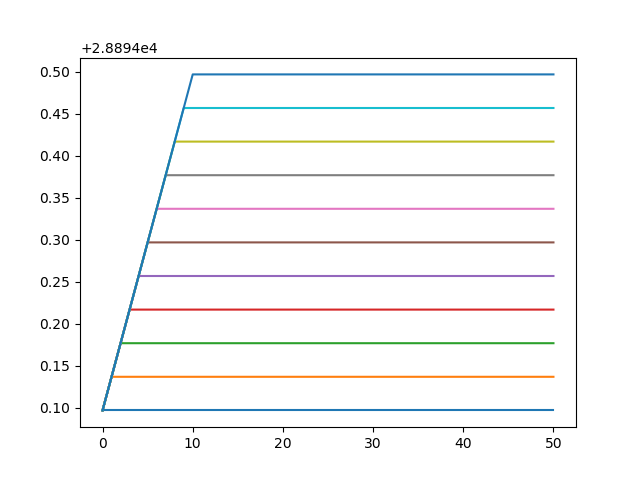

In [160]:
ac, rho, ua = 1, 1, 1
dt, dx = 0.1, 0.1
m_hot = 10
m_cold = 1
p = 1e5
temp_hot_inlet = 300
temp_cold_inlet = 280
h_hot_inlet = CP.PropsSI('H','T',temp_hot_inlet,'P',p,'water')
h_cold_inlet = CP.PropsSI('H','T',temp_cold_inlet,'P',p,'water')
J = 50
ua_cell = ua / J

h_hot = numpy.ones(J+1) * h_hot_inlet
h_cold = numpy.ones(J+1) * h_cold_inlet

fig=plt.figure()
plt.plot(h_cold)

for n in range(10):
    
    # Compute the forcing terms
    temp_hot = CP.PropsSI('T','H', h_hot, 'P', p, 'water')
    temp_cold = CP.PropsSI('T','H', h_cold, 'P', p, 'water')
    c_hot = CP.PropsSI('C','H', h_hot, 'P', p, 'water')
    c_cold = CP.PropsSI('C','H', h_cold, 'P', p, 'water')
    c_min_cells = c_cold[:-1]
    c_r_cells = (m_cold * c_cold[:-1]) / (m_hot * c_hot[1:])
    Q_max = c_min_cells * (temp_hot[1:] - temp_cold[:-1])
    NTU = ua_cell / c_min_cells
    effect = counterflow_effectiveness(NTU, c_r_cells)
    Q_load_cells = effect * Q_max
    
    b_cold = numpy.zeros(J+1)
    b_cold[0] = h_cold_inlet
    b_cold[1:] = Q_load_cells + ac * rho / dt * h_cold[:-1]
    a_cold = numpy.zeros((J+1,J+1))
    # Assigning to diagonal doesn't work in numpy 
    # a_cold.diagonal(0) = m_cold / dx
    # a_cold.diagonal(-1) = ac * rho / dt - m_cold / dx
    a_cold[0,0] = 1
    for j in range(J):
        a_cold[j+1,j] += ac * rho / dt - m_cold / dx
        a_cold[j+1,j+1] += m_cold/dx
    
    b_hot = h_hot
    b_hot[-1] = h_hot_inlet
    a_hot = numpy.eye(J+1,J+1)
    
    h_hot = numpy.linalg.solve(a_hot, b_hot)
    h_cold = numpy.linalg.solve(a_cold, b_cold)
    
    plt.plot(h_cold)
    fig.canvas.draw()
plt.show()

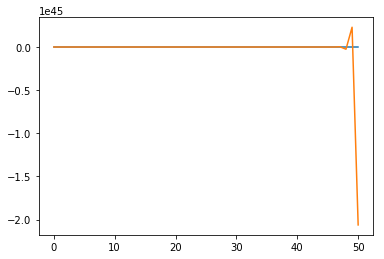

In [150]:
plt.show()

In [149]:
h_cold

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])